In [55]:
import numpy as np
import sqlite3
import plotly.express as px
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from useful_functions import *
from pdf2image import convert_from_path
from sklearn.manifold import TSNE
from scipy.spatial.distance import braycurtis
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist
from skbio.stats.distance import DistanceMatrix

In [56]:
tables_to_join = ["tSoilMicrobeGenera", "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
full_df.shape

(394056, 15)

In [57]:
full_df = full_df.T.drop_duplicates().T

In [58]:
full_df.head()

,sample_id,genera,relative_abundance,site_id,collect_date,V1,V2,species,PC1,PC2,PC3,PC4,PC5
0,SLG1,Archaea|Candidatus Korarchaeota||||Candidatus ...,0.0,SLG,6/28/2021,0.526443,0.473557,exaltata,0.073306,0.124888,-0.018603,-0.017475,-0.01556
1,SLG2,Archaea|Candidatus Korarchaeota||||Candidatus ...,0.0,SLG,6/28/2021,0.681954,0.318046,exaltata,0.147793,0.059165,-0.024549,-0.011129,-0.034775
2,SLG3,Archaea|Candidatus Korarchaeota||||Candidatus ...,0.0,SLG,6/28/2021,0.551843,0.448157,exaltata,0.073801,0.128018,0.000022,-0.004363,0.007745
3,SLG4,Archaea|Candidatus Korarchaeota||||Candidatus ...,0.0,SLG,6/28/2021,0.587473,0.412527,exaltata,0.111079,0.098371,-0.010988,-0.010209,0.012289
4,SLG5,Archaea|Candidatus Korarchaeota||||Candidatus ...,0.0,SLG,6/28/2021,0.692085,0.307915,exaltata,0.131353,0.081502,0.007733,0.00689,0.019975


In [59]:
full_df.shape

(394056, 13)

In [60]:
df = full_df.copy()

In [61]:
subdf = df.copy()

In [62]:
origin_pivoted_df = subdf.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='genera', values='relative_abundance')
origin_pivoted_df.shape

row_sum = origin_pivoted_df.sum(axis=1)

origin_pivoted_df = origin_pivoted_df.reset_index()

genera_col = origin_pivoted_df.columns
genera_col = genera_col.drop(['sample_id','site_id', 'species', 'V2'])

sub_pivot = origin_pivoted_df[genera_col].astype(float)

for row in range(sub_pivot.shape[0]):
    sub_pivot.loc[row] = sub_pivot.loc[row]/row_sum[row]

new_sum = sub_pivot.sum(axis=1)
new_sum

origin_pivoted_df[genera_col] = sub_pivot

origin_pivoted_df.head()

row_sum = origin_pivoted_df[genera_col].sum(axis=1)
print(row_sum)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
151    1.0
152    1.0
153    1.0
154    1.0
155    1.0
Length: 156, dtype: float64


In [63]:
origin_pivoted_df.shape

(156, 2530)

In [64]:
sum_row = origin_pivoted_df[genera_col].sum()

abundant_genera = sum_row.nlargest(100)

select_columns = (abundant_genera.index).tolist()
select_columns.insert(0, 'V2')
select_columns.insert(0, 'sample_id')
select_columns.insert(0, 'site_id')
select_columns.insert(0, 'species')

origin_pivoted_df = origin_pivoted_df[select_columns]

origin_pivoted_df.head()

genera,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,Bacteria|Actinobacteria|Actinobacteria|Streptomycetales|Streptomycetaceae|Streptomyces,Bacteria|Cyanobacteria||Synechococcales|Synechococcaceae|Synechococcus,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Cyanobacteria||Synechococcales|Synechococcaceae|Thermosynechococcus,Viruses|||Caudovirales|Podoviridae|T7virus,...,Bacteria|Actinobacteria|Actinobacteria|Pseudonocardiales|Pseudonocardiaceae|Saccharomonospora,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Hyphomicrobiaceae|Rhodoplanes,Bacteria|Actinobacteria|Actinobacteria|Micrococcales|Microbacteriaceae|Agromyces,Bacteria|Proteobacteria|Alphaproteobacteria|Caulobacterales|Caulobacteraceae|Phenylobacterium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Hyphomicrobiaceae|Devosia,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Xanthomonadaceae|Pseudoxanthomonas,Bacteria|Cyanobacteria||Nostocales|Rivulariaceae|Calothrix,Bacteria|Actinobacteria|Actinobacteria|Propionibacteriales|Nocardioidaceae|Marmoricola,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Rhodanobacteraceae|Dyella,Bacteria|Proteobacteria|Betaproteobacteria|Neisseriales|Chromobacteriaceae|Pseudogulbenkiania
0,syriaca,CMB,CMB10,0.999777,0.093727,0.080597,0.000510,0.024729,0.000000,0.0,...,0.002773,0.003830,0.003073,0.002865,0.003050,0.002961,0.000051,0.002156,0.004247,0.002362
1,syriaca,CMB,CMB11,1.000000,0.097675,0.082029,0.000599,0.033588,0.000049,0.0,...,0.002086,0.003294,0.002509,0.004020,0.003743,0.001623,0.000034,0.002613,0.005018,0.001533
2,syriaca,CMB,CMB13,0.989131,0.122075,0.100412,0.000539,0.031240,0.000000,0.0,...,0.003591,0.003552,0.002541,0.001933,0.002948,0.001189,0.000019,0.001754,0.002370,0.002668
3,syriaca,CMB,CMB15,0.998548,0.149311,0.080603,0.000000,0.067397,0.000000,0.0,...,0.002311,0.001997,0.000371,0.002624,0.004062,0.000709,0.000000,0.001864,0.001575,0.002413
4,syriaca,CMB,CMB16,0.999243,0.098761,0.092399,0.000494,0.049438,0.000000,0.0,...,0.003103,0.003978,0.002764,0.002287,0.003261,0.001007,0.000054,0.002302,0.002043,0.001771


In [65]:
opdf = origin_pivoted_df.copy()
microbe_cols = abundant_genera.index

In [66]:
# opdf[microbe_cols] = StandardScaler().fit_transform(opdf[microbe_cols])  

In [67]:
opdf.head()

genera,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,Bacteria|Actinobacteria|Actinobacteria|Streptomycetales|Streptomycetaceae|Streptomyces,Bacteria|Cyanobacteria||Synechococcales|Synechococcaceae|Synechococcus,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Cyanobacteria||Synechococcales|Synechococcaceae|Thermosynechococcus,Viruses|||Caudovirales|Podoviridae|T7virus,...,Bacteria|Actinobacteria|Actinobacteria|Pseudonocardiales|Pseudonocardiaceae|Saccharomonospora,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Hyphomicrobiaceae|Rhodoplanes,Bacteria|Actinobacteria|Actinobacteria|Micrococcales|Microbacteriaceae|Agromyces,Bacteria|Proteobacteria|Alphaproteobacteria|Caulobacterales|Caulobacteraceae|Phenylobacterium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Hyphomicrobiaceae|Devosia,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Xanthomonadaceae|Pseudoxanthomonas,Bacteria|Cyanobacteria||Nostocales|Rivulariaceae|Calothrix,Bacteria|Actinobacteria|Actinobacteria|Propionibacteriales|Nocardioidaceae|Marmoricola,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Rhodanobacteraceae|Dyella,Bacteria|Proteobacteria|Betaproteobacteria|Neisseriales|Chromobacteriaceae|Pseudogulbenkiania
0,syriaca,CMB,CMB10,0.999777,0.093727,0.080597,0.000510,0.024729,0.000000,0.0,...,0.002773,0.003830,0.003073,0.002865,0.003050,0.002961,0.000051,0.002156,0.004247,0.002362
1,syriaca,CMB,CMB11,1.000000,0.097675,0.082029,0.000599,0.033588,0.000049,0.0,...,0.002086,0.003294,0.002509,0.004020,0.003743,0.001623,0.000034,0.002613,0.005018,0.001533
2,syriaca,CMB,CMB13,0.989131,0.122075,0.100412,0.000539,0.031240,0.000000,0.0,...,0.003591,0.003552,0.002541,0.001933,0.002948,0.001189,0.000019,0.001754,0.002370,0.002668
3,syriaca,CMB,CMB15,0.998548,0.149311,0.080603,0.000000,0.067397,0.000000,0.0,...,0.002311,0.001997,0.000371,0.002624,0.004062,0.000709,0.000000,0.001864,0.001575,0.002413
4,syriaca,CMB,CMB16,0.999243,0.098761,0.092399,0.000494,0.049438,0.000000,0.0,...,0.003103,0.003978,0.002764,0.002287,0.003261,0.001007,0.000054,0.002302,0.002043,0.001771


In [68]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)


In [69]:
opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]
opdf.shape

(87, 105)

In [70]:
df = opdf

In [71]:
site_list = df['site_id']

df['BGR'] = site_list

df['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
df = df[df["BGR"].isin([0,1,2,3])]

df['BGR'] = df['BGR'].replace([0], 'Wintergreen')
df['BGR'] = df['BGR'].replace([1], 'Cole Mountain')
df['BGR'] = df['BGR'].replace([2], 'Blacksburg')
df['BGR'] = df['BGR'].replace([3], 'HR')

In [72]:
site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


In [73]:
df = df.reset_index()
df.head()

genera,index,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,Bacteria|Actinobacteria|Actinobacteria|Streptomycetales|Streptomycetaceae|Streptomyces,Bacteria|Cyanobacteria||Synechococcales|Synechococcaceae|Synechococcus,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Cyanobacteria||Synechococcales|Synechococcaceae|Thermosynechococcus,...,Bacteria|Actinobacteria|Actinobacteria|Micrococcales|Microbacteriaceae|Agromyces,Bacteria|Proteobacteria|Alphaproteobacteria|Caulobacterales|Caulobacteraceae|Phenylobacterium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Hyphomicrobiaceae|Devosia,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Xanthomonadaceae|Pseudoxanthomonas,Bacteria|Cyanobacteria||Nostocales|Rivulariaceae|Calothrix,Bacteria|Actinobacteria|Actinobacteria|Propionibacteriales|Nocardioidaceae|Marmoricola,Bacteria|Proteobacteria|Gammaproteobacteria|Xanthomonadales|Rhodanobacteraceae|Dyella,Bacteria|Proteobacteria|Betaproteobacteria|Neisseriales|Chromobacteriaceae|Pseudogulbenkiania,seq_id,BGR
0,0,syriaca,CMB,CMB10,0.999777,0.093727,0.080597,0.000510,0.024729,0.000000,...,0.003073,0.002865,0.003050,0.002961,0.000051,0.002156,0.004247,0.002362,3,Cole Mountain
1,1,syriaca,CMB,CMB11,1.000000,0.097675,0.082029,0.000599,0.033588,0.000049,...,0.002509,0.004020,0.003743,0.001623,0.000034,0.002613,0.005018,0.001533,3,Cole Mountain
2,2,syriaca,CMB,CMB13,0.989131,0.122075,0.100412,0.000539,0.031240,0.000000,...,0.002541,0.001933,0.002948,0.001189,0.000019,0.001754,0.002370,0.002668,3,Cole Mountain
3,3,syriaca,CMB,CMB15,0.998548,0.149311,0.080603,0.000000,0.067397,0.000000,...,0.000371,0.002624,0.004062,0.000709,0.000000,0.001864,0.001575,0.002413,3,Cole Mountain
4,4,syriaca,CMB,CMB16,0.999243,0.098761,0.092399,0.000494,0.049438,0.000000,...,0.002764,0.002287,0.003261,0.001007,0.000054,0.002302,0.002043,0.001771,3,Cole Mountain


In [74]:
X = df[microbe_cols]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

drop_indexs = []
for i in enumerate(principal_components):
    if i[1][0] > 0.5:
        print(i)
        drop_indexs.append(i[0])
    if i[1][1] > 0.5:
        print(i)
        drop_indexs.append(i[0])
        
df = df.drop(index=drop_indexs)

(47, array([0.69325576, 0.02167802]))


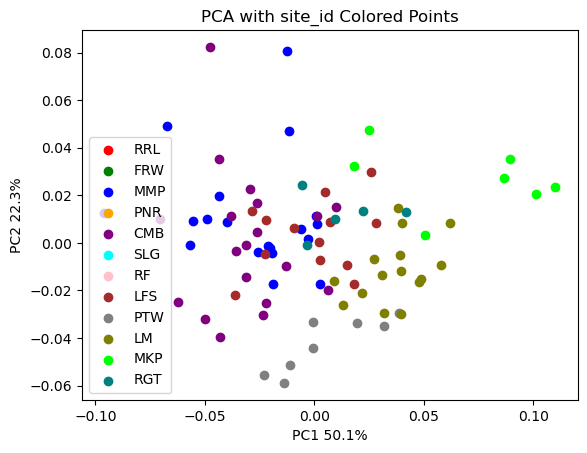

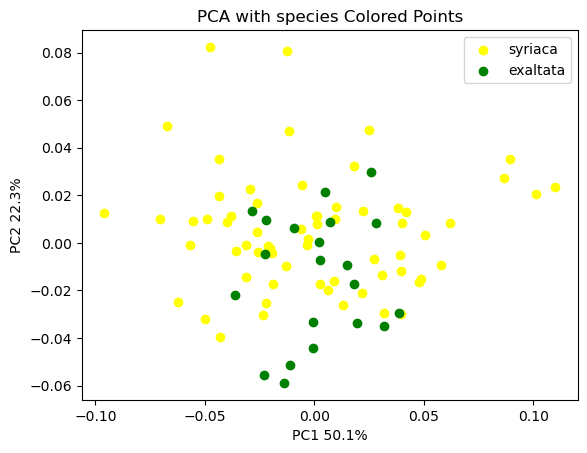

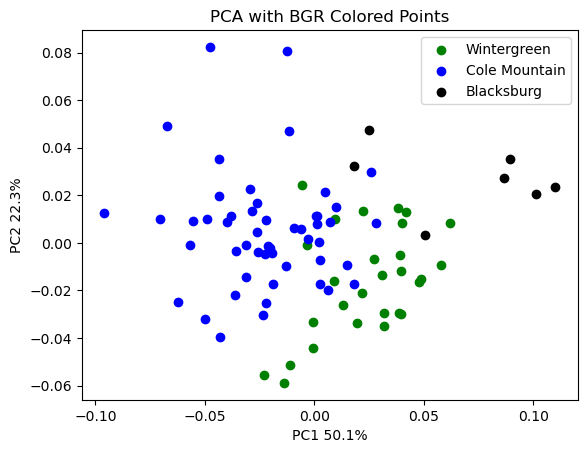

In [75]:
X = df[microbe_cols]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('PCA of Field Sites and Soil Microbiome')
        fig1 = fig
    elif graph_type == 'species':
        ax.set_title('PCA of Plant Species and Soil Microbiome')
        fig2 = fig
    else:
        ax.set_title('PCA of Broad Geographic Region and Soil Microbiome')
        fig3 = fig

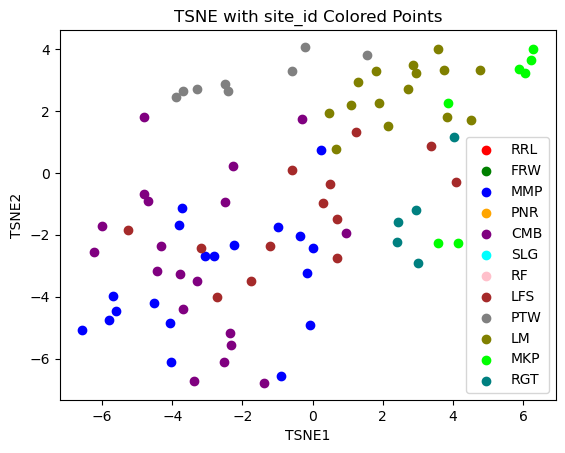

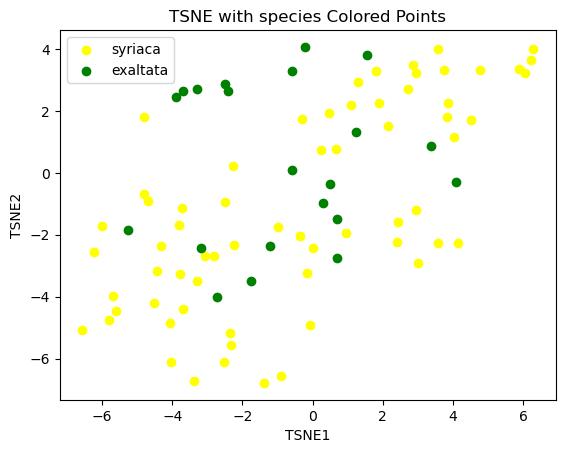

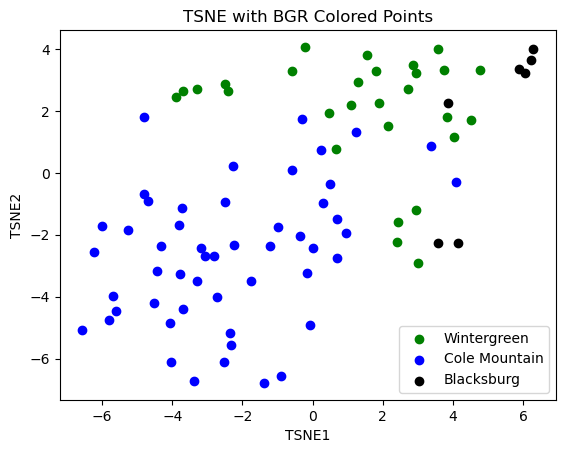

In [76]:
perplexity_value = 25 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=43)
tsne_transformed = tsne.fit_transform(df[microbe_cols])


for graph_type in ['site_id', 'species', 'BGR']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    else:
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}

    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Field Site and Soil Microbiome, P.V. = ' + str(perplexity_value))
        fig4 = fig
    elif graph_type == 'species':
        ax.set_title('TSNE of Plant Species and Soil Microbiome, P.V. = ' + str(perplexity_value))
        fig5 = fig
    else:
        ax.set_title('TSNE of Broad Geographic Region and Soil Microbiome, P.V. = ' + str(perplexity_value))
        fig6 = fig

In [48]:
dis_matrix = pdist(df[microbe_cols], 'braycurtis')
from skbio.stats.distance import DistanceMatrix
fin_matrix = DistanceMatrix(dis_matrix)
permanova_site = permanova(fin_matrix, grouping = df['site_id'])
permanova_bgr = permanova(fin_matrix, grouping = df['BGR'])
permanova_species = permanova(fin_matrix, grouping = df['species'])


print(permanova_site)
print('')
print(permanova_bgr)
print('')
print(permanova_species)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      86
number of groups                  7
test statistic             12.32574
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      86
number of groups                  3
test statistic             19.89451
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      86
number of groups                  2
test statistic             2.212318
p-value                       0.071
number of permutations          999
Name: PERMANOVA results, dtype: object


In [81]:
v2_list = []
for i in df['V2']:
    v2_list.append(i)
    
v2_list.sort()
v2_list

[1.46e-06,
 0.060469465,
 0.110320222,
 0.141064807,
 0.150532867,
 0.190611213,
 0.198886866,
 0.221165635,
 0.242603207,
 0.24507513,
 0.24624796,
 0.249776299,
 0.250345752,
 0.254647149,
 0.27031741800000003,
 0.313959884,
 0.331716367,
 0.377154042,
 0.388694493,
 0.415349998,
 0.5342088110000001,
 0.7881207709999999,
 0.904952487,
 0.9093784,
 0.920482076,
 0.921160983,
 0.921600652,
 0.928784175,
 0.931411864,
 0.9416044,
 0.945970293,
 0.947113913,
 0.950022725,
 0.961333795,
 0.964799716,
 0.966110769,
 0.969494357,
 0.970629199,
 0.976830919,
 0.977027431,
 0.982562258,
 0.982635596,
 0.983129509,
 0.985847727,
 0.986708141,
 0.988045417,
 0.989130596,
 0.992059724,
 0.993886933,
 0.993939326,
 0.994411087,
 0.99612139,
 0.99613745,
 0.998350817,
 0.998547653,
 0.998593042,
 0.99897665,
 0.999080836,
 0.999243483,
 0.999282893,
 0.999508419,
 0.999777121,
 0.999846434,
 0.999880149,
 0.999935194,
 0.999937501,
 0.999971273,
 0.99997927,
 0.999987456,
 0.99998903,
 0.999993011

In [49]:
wdf = df[df['BGR'] == 'Wintergreen']
cmdf = df[df['BGR'] == 'Cole Mountain']
bdf = df[df['BGR'] == 'Blacksburg']

In [52]:
#wintergreen
print(wdf['site_id'].unique())
dis_matrix = pdist(wdf[microbe_cols], 'braycurtis')
from skbio.stats.distance import DistanceMatrix
fin_matrix = DistanceMatrix(dis_matrix)
permanova_site = permanova(fin_matrix, grouping = wdf['site_id'])
permanova_site

['LM' 'PTW' 'RGT']


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      28
number of groups                  3
test statistic              8.78985
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [53]:
#cole mountain
print(cmdf['site_id'].unique())
dis_matrix = pdist(cmdf[microbe_cols], 'braycurtis')
from skbio.stats.distance import DistanceMatrix
fin_matrix = DistanceMatrix(dis_matrix)
permanova_site = permanova(fin_matrix, grouping = cmdf['site_id'])
permanova_site

['CMB' 'LFS' 'MMP']


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      51
number of groups                  3
test statistic             5.728129
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [54]:
#blacksburg
print(bdf['site_id'].unique())
dis_matrix = pdist(bdf[microbe_cols], 'braycurtis')
from skbio.stats.distance import DistanceMatrix
fin_matrix = DistanceMatrix(dis_matrix)
permanova_site = permanova(fin_matrix, grouping = bdf['site_id'])
permanova_site

['MKP']


ValueError: All values in the grouping vector are the same. This method cannot operate on a grouping vector with only a single group of objects (e.g., there are no 'between' distances because there is only a single group).

In [25]:
dis_matrix = pdist(df[microbe_cols], 'braycurtis')
#dissimilarity_matrix = braycurtis(df['Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium'], df['Bacteria|Actinobacteria|Actinobacteria|Streptomycetales|Streptomycetaceae|Streptomyces'],  df['Bacteria|Proteobacteria|Alphaproteobacteria|Caulobacterales|Caulobacteraceae|Phenylobacterium'])

In [26]:
dis_matrix

array([0.0774315 , 0.12993721, 0.1951198 , ..., 0.13890406, 0.1472479 ,
       0.11456818])

In [27]:
from skbio.stats.distance import DistanceMatrix
fin_matrix = DistanceMatrix(dis_matrix)

In [28]:
permanova_site = permanova(fin_matrix, grouping = df['site_id'])
permanova_bgr = permanova(fin_matrix, grouping = df['BGR'])
permanova_species = permanova(fin_matrix, grouping = df['species'])


print(permanova_site)
print('')
print(permanova_bgr)
print('')
print(permanova_species)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      86
number of groups                  7
test statistic             12.32574
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      86
number of groups                  3
test statistic             19.89451
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      86
number of groups                  2
test statistic             2.212318
p-value                       0.075
number of permutations          999
Name: PERMANOVA results, dtype: object


In [29]:
from skbio import DistanceMatrix

abundance_data = df[microbe_cols].values

# Calculate pairwise Bray-Curtis dissimilarity matrix
# Consider the repeated measures within each site
dissimilarities = []
sites = df['site_id'].unique()
for site in sites:
    print(site)
    site_data = df[df['site_id'] == site][microbe_cols].values
    site_data = [1,2,3,4]
    site_dist_matrix = DistanceMatrix.from_iterable(site_data, metric='braycurtis')
    dissimilarities.append(site_dist_matrix.data)

# Combine dissimilarity matrices for all sites
combined_dissimilarities = np.concatenate(dissimilarities)

# Create grouping vector considering repeated measures
grouping = np.repeat(sites, [len(site_data) for site_data in dissimilarities])

# Perform PERMANOVA
permanova_results = permanova(DistanceMatrix(combined_dissimilarities), grouping=grouping)


CMB


TypeError: 'str' object is not callable

In [ ]:

# Perform PERMANOVA using ANOVA F-test
#permanova_bgr = f_oneway(*[dissimilarities[df['BGR'] == bgr] for bgr in df['BGR'].unique()])
permanova_site = f_oneway(*[dissimilarities[df['site_id'] == site_id] for site_id in df['site_id'].unique()])
permanova_species = f_oneway(*[dissimilarities[df['species'] == species] for species in df['species'].unique()])

print(permanova_bgr)
print(permanova_site)
print(permanova_species)

In [ ]:
abundance_data = df[['bact1', 'bact2', 'bact3', 'bact4']].values
bc_dissimilarity = DistanceMatrix.from_iterable(abundance_data, metric='braycurtis')


In [ ]:
### Save Figures and Create Final Figure
fig1.savefig('soil_microbe_site_id.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('soil_microbe_species.pdf', dpi=300, bbox_inches='tight')
fig3.savefig('soil_microbe_bgr.pdf', dpi=300, bbox_inches='tight')
fig4.savefig('soil_microbe_site_id_tsne.pdf', dpi=300, bbox_inches='tight')
fig5.savefig('soil_microbe_species_tsne.pdf', dpi=300, bbox_inches='tight')
fig6.savefig('soil_microbe_bgr_tsne.pdf', dpi=300, bbox_inches='tight')

img1=convert_from_path('soil_microbe_site_id.pdf')
img2=convert_from_path('soil_microbe_bgr.pdf')
img3=convert_from_path('soil_microbe_species.pdf')
img4=convert_from_path('soil_microbe_site_id_tsne.pdf')
img5=convert_from_path('soil_microbe_bgr_tsne.pdf')
img6=convert_from_path('soil_microbe_species_tsne.pdf')



fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax[0][0].imshow(img1[0])
ax[0][1].imshow(img4[0])
ax[1][0].imshow(img2[0])
ax[1][1].imshow(img5[0])
ax[2][0].imshow(img3[0])
ax[2][1].imshow(img6[0])

# plot 2 subplots
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[2][0].axis('off')
ax[2][1].axis('off')

ax[0][0].annotate("A", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][0].annotate("C", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[0][1].annotate("B", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[1][1].annotate("D", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][0].annotate("E", xy=(-0.05, 0.9), xycoords="axes fraction")
ax[2][1].annotate("F", xy=(-0.05, 0.9), xycoords="axes fraction")


fig.suptitle('Soil Microbes can be grouped by Broad Geographic Region')
plt.tight_layout()
plt.show()

fig.savefig('combined_Soil_microbes.pdf', bbox_inches='tight', dpi = 1000)

### Investigating Breakdown of Genera

In [ ]:
origin_pivoted_df.columns

In [ ]:
opdf=origin_pivoted_df

In [ ]:
### Reduce the data by removing Sequence Run 1
libdf = pd.read_csv('lib_samples.csv')

sample_list = opdf['sample_id']
opdf['seq_id'] = sample_list

for sample1 in libdf['lib_one']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample1], '1')
for sample2 in libdf['lib_two']:
    opdf['seq_id'] = opdf['seq_id'].replace([sample2], '2')
    
sample_list = opdf['seq_id'].unique().tolist()
sample_list.remove('1')
#sample_list.remove('2')
opdf['seq_id'].replace(sample_list, "3", inplace=True)

opdf = opdf[opdf['seq_id'].isin(['3'])]
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]
opdf.shape

In [ ]:
opdf

In [ ]:
bardf = opdf.drop(['site_id', 'species', 'V2', 'seq_id'], axis=1)
bardf.head()

In [ ]:
max_i = 0
for i in bardf['Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Mycobacteriaceae|Mycobacterium']:
    if i > max_i:
        max_i = i
print(max_i)

In [ ]:
for i in bardf['sample_id']:
    print(i)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cumval=0
fig = plt.figure(figsize=(12,8))
for col in bardf.columns[~bardf.columns.isin(['sample_id'])]:
    plt.bar(bardf.sample_id, bardf[col], bottom=cumval, label = col)
    cumval = cumval+bardf[col]
    print(col)

_ = plt.xticks(rotation=30)
_ = plt.legend(fontsize=18)

leg = plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1.05))